In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_features_num_regression(
    df: pd.DataFrame,
    target_col: str = "",
    columns: list[str] = [],
    umbral_corr: float = 0,
    pvalue: float | None = None
):
    """
    ENUNCIADO (cumplido):
    - args: df, target_col="", columns=[], umbral_corr=0, pvalue=None
    - si columns vacía -> usa todas las numéricas del df (excepto target)
    - filtra columns por |corr| > umbral_corr
    - si pvalue != None -> además p < pvalue (Pearson)
    - pinta pairplot de target + columnas filtradas
    - EXTRA: paginación: varios pairplots con máx 5 columnas + target
    - devuelve la lista final de columnas filtradas
    - si inputs inválidos: print razón + return None
    """

    # Checks de entrada (inválido -> None)
    if not isinstance(df, pd.DataFrame):
        print("Error: df debe ser un pandas DataFrame.")
        return None

    if not isinstance(target_col, str) or target_col == "":
        print("Error: target_col debe ser un string no vacío.")
        return None

    if target_col not in df.columns:
        print("Error: target_col no existe en df.columns.")
        return None

    if not pd.api.types.is_numeric_dtype(df[target_col]):
        print("Error: target_col debe ser numérica (target de regresión).")
        return None

    if not isinstance(umbral_corr, (int, float)) or not (0 <= float(umbral_corr) <= 1):
        print("Error: umbral_corr debe ser un número entre 0 y 1.")
        return None
    umbral_corr = float(umbral_corr)

    if pvalue is not None:
        if not isinstance(pvalue, (int, float)) or not (0 < float(pvalue) < 1):
            print("Error: pvalue debe ser None o un float entre 0 y 1 (ej. 0.05).")
            return None
        pvalue = float(pvalue)

    if columns is None or not isinstance(columns, list):
        print("Error: columns debe ser una lista de strings (puede ser vacía).")
        return None
    if len(columns) > 0 and not all(isinstance(c, str) for c in columns):
        print("Error: columns debe contener solo strings (nombres de columnas).")
        return None

    # Preparar columns 
    if len(columns) == 0:
        # todas las numéricas excepto target
        columns = df.select_dtypes(include="number").columns.tolist()
        columns = [c for c in columns if c != target_col]
    else:
        # validar existencia y tipo numérico
        missing = [c for c in columns if c not in df.columns]
        if missing:
            print(f"Error: columns contiene columnas inexistentes: {missing}")
            return None
        non_num = [c for c in columns if not pd.api.types.is_numeric_dtype(df[c])]
        if non_num:
            print(f"Error: columns contiene columnas no numéricas: {non_num}")
            return None
        columns = [c for c in columns if c != target_col]

    if len(columns) == 0:
        print("Error: no hay columnas numéricas para comparar con target_col.")
        return None

    # Filtro por correlación
    corr_abs = df[[target_col] + columns].corr(numeric_only=True)[target_col].abs()
    corr_abs = corr_abs.drop(labels=[target_col], errors="ignore")
    selected = corr_abs[corr_abs > umbral_corr].index.tolist()

    if len(selected) == 0:
        print("No hay columnas que cumplan |corr| > umbral_corr.")
        return []  # entrada válida, resultado vacío

    # Filtro por pvalue (opcional)
    if pvalue is not None:
        try:
            from scipy.stats import pearsonr
        except Exception:
            print("Error: no se pudo importar scipy.stats.pearsonr para calcular p-values.")
            return None

        passed = []
        for col in selected:
            tmp = df[[col, target_col]].dropna()
            if len(tmp) < 3 or tmp[col].nunique() < 2 or tmp[target_col].nunique() < 2:
                continue
            r, p = pearsonr(tmp[col], tmp[target_col])
            if p < pvalue:
                passed.append(col)

        selected = passed

        if len(selected) == 0:
            print("No hay columnas que cumplan umbral_corr y además p-value < pvalue.")
            return []

    # Pairplot con paginación (máx 5 cols + target)
    def _plot_pairplot(df_plot: pd.DataFrame, title: str):
        # Intentamos seaborn (queda mejor). Si no está, fallback a scatter_matrix (más básico)
        try:
            import seaborn as sns
            g = sns.pairplot(df_plot, diag_kind="hist", corner=False, plot_kws={"alpha": 0.6})
            g.fig.suptitle(title, y=1.02)
            plt.show()
        except Exception:
            pd.plotting.scatter_matrix(
                df_plot,
                figsize=(3 * df_plot.shape[1], 3 * df_plot.shape[1]),
                diagonal="hist",
                alpha=0.6
            )
            plt.suptitle(title, y=1.02)
            plt.tight_layout()
            plt.show()

    max_cols = 5
    for i in range(0, len(selected), max_cols):
        chunk = selected[i:i + max_cols]
        cols_to_plot = [target_col] + chunk
        df_plot = df[cols_to_plot].dropna()

        title = f"Pairplot: target={target_col} | cols {i+1}-{i+len(chunk)} de {len(selected)}"
        _plot_pairplot(df_plot, title)

    # Return obligatorio 
    return selected


In [2]:
df=pd.read_csv("./data/titanic.csv")

## `plot_features_num_regression`

- **`target_col`**: variable objetivo (numérica).
- **`columns`**: columnas a evaluar (`[]` → todas las numéricas).
- **`umbral_corr`**: mínimo de `|corr|` con el target.
- **`pvalue`**: test de Pearson (`p < pvalue`).

La función:
- selecciona las variables que cumplen los criterios,
- pinta *pairplots* (máx. 5 columnas + target),
- devuelve la lista de columnas seleccionadas.

```python
cols_ok = plot_features_num_regression(df, "age", [], 0.2, 0.05)


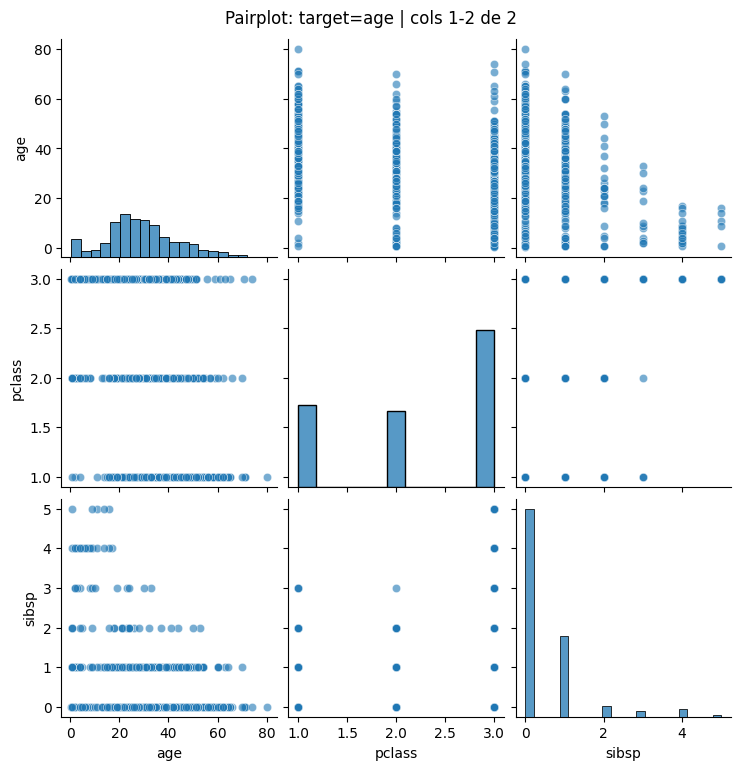

['pclass', 'sibsp']

In [4]:
cols_ok = plot_features_num_regression(df, target_col="age", columns=[], umbral_corr=0.2, pvalue=0.05)
cols_ok
